In [1]:
### PREAMBLE
# Uniform convergence may be unable to explain generalization in deep learning
# Empirical and theoretical evidence demonstrating that uniform convergence based generalization bounds may be meaningless for overparameterized deep networks trained by stochastic gradient descent.
# Vaishnavh Nagarajan
# header.png

import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output
import itertools
from IPython.core.display import HTML


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#mpl.rcParams['figure.dpi']= 300 
mpl.rcParams['font.family'] = 'monospace'


def get_random_data(n_points, input_dim=10, inner_radius=1, outer_radius=1.1):
    """ Generates random data from the hypersphere distribution used in the blog"""
    '''
    Inputs: 
    n_points (int): number of points to be sampled
    input_dim (int): dimensionality of hypersphere
    inner_radius (float): radius of inner sphere
    outer_radius (flouat): radius of outer sphere
    
    Output:
    data (n_points x input_dim datapoints  np.array): sampled datapoints
    labels (n_points x 2  np.array): 1-hot encoding of labels
    '''
    data = np.random.normal(size=(n_points,input_dim)) 
    labels = np.zeros(shape=(n_points,2))

    for i in range(n_points):
        if np.random.uniform() > 0.5:
            labels[i,0] = 1
            data[i,:] = inner_radius*(data[i,:]/np.linalg.norm(data[i,:]))
        else:
            labels[i,1] = 1
            data[i,:] = outer_radius*data[i,:]/np.linalg.norm(data[i,:])    

    return data, labels 

# A function to create a TF linear transformation layer
def linear(input_var, input_dim, output_dim, scope=None):
    """ Creates tensorflow graph for linear transformation of a layer"""
    '''
    Inputs: 
    input_var (tf variable): input to the linear transformation
    input_dim (int): dimensionality of input layer
    output_dim (int): dimensionality of output layer
    scope: scope of the variable
    
    Output: linearly transformed layer
    '''
    initializer = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input_var.get_shape()[1], output_dim], initializer=initializer)
        b = tf.get_variable('b',[1,output_dim])
        return tf.matmul(input_var, w)  + b


def get_network(input_var, input_dim, output_dim, width, depth):
    """ Creates the tf graph for the deep ReLU network """
    '''
    Inputs: 
    input_var (tf variable): input to the deep network
    input_dim (int): dimensionality of input layer
    output_dim (int): dimensionality of output layer (number of classes, essentially)
    width (int): number of hidden units per layer
    depth (int >= 2): number of layers in the network
    
    Output: output layer of the deep network
    '''
    
    curr_output = linear(input_var, input_dim, width, scope='0')
    curr_output = tf.nn.relu(curr_output)
    for k in range(depth-2):
        curr_output = tf.nn.relu(linear(curr_output, width, width,scope=str(k+1)))
    curr_output= linear(curr_output, width, output_dim,scope=str(depth-1))     #final layer is just linear
    return curr_output


def reinitialize_weights(weights, placeholder, op):
    """ Executes an op which assigns values to a tf variable from a placeholder """
    '''
    Inputs: 
    weights (a list of np.array): a list of values that will be assigned to a list of tf variables
    placeholder (a list of tf placeholder): a list of placeholders which will carry the weights
    op (tf op): a tensorflow operation that assigns the weights 
                from placeholder llist to some other list of tf variables 
    '''
    
    
    feed_dict = {}
    for k in range(len(placeholder)):
        feed_dict[placeholder[k]] = weights[k]
    return sess.run(op, feed_dict = feed_dict)






def perform_op_over_data(inputs, labels, op, input_ph, label_ph, flags):
    """ Executes an op over all batches in a dataset """
    '''
    Inputs: 
    inputs (np.array): datapoints
    labels (np.array): the labels of the datapoints
    op (tf operation): operation to be executed
    input_ph (tf placeholder): the input placeholder to the deep network
    label_ph (tf placeholder): the label placeholder for the loss function on the deep network
    flags (dict): a dictionary of hyperparameters containing "batch_size" as a key
    
    Output: a list of outputs from the tf run of the ops on each batch in the dataset
    '''
    
    outputs = []
    max_batch_ind = int(inputs.shape[0]/flags["batch_size"])
    for batch_ind in range(max_batch_ind):
        curr_indices = np.array(range(flags["batch_size"]*batch_ind,flags["batch_size"]*(batch_ind+1)))
        outputs += [sess.run(op, 
            feed_dict={input_ph: inputs[curr_indices], 
                label_ph: labels[curr_indices]})]
    return outputs







# Code for changing Matlab aesthetics
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('text', usetex=False)

# A list of colors and markers that we will iterate through
colors = itertools.cycle(['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00'])
markers = itertools.cycle([ 'h', '*', '<', 'o', 's', 'v', 'D' ])

# The following functions will be of use in transforming the x and y axes in our plots
def log10(x):
    """ Computes log to the base ten for a float """
    return np.log(x)/np.log(10)

def identity(x):
    """ Computes identity function"""
    return x

def plot_figure(xtitle, ytitle, x, y, xticks, ylabels=None, x_transform = log10):
    """ Plots matlab figure """
    '''
    Input:
    xtitle (string): a label for the x axis
    ytitle (string): a label for the y axis
    x (list of floats): a list of x coordinates for which the y coordinate will be plotted
    y (list or a list of lists of floats):  a list of y coordinates or a list of list of y coordinates corresponding
                                  to each line in the plot
    xticks (list of floats): a list of x coordinates which will be marked
    ylabels (a list of strings): label for each line that'll be plotted (None if just a single line)
    x_transform (function): transformation to be applied on the x axis
    
    Output: prints a log-log plot (if y is a list of lists, all the y lists are combined in one plot and
    a legend is added)
    '''
    fig= plt.figure(figsize=(3,3))
    ax = plt.subplot(111)
    ax.set_xlabel(xtitle,fontsize=12)
    ax.set_xticks(log10(x))
    ax.set_xticklabels(xticks)

    ax.set_ylabel("log("+ytitle+")",fontsize=12)
        
    if ylabels is not None:
        for t in range(len(ylabels)):
            color = next(colors)
            marker = next(markers)
            ax.plot(x_transform(x), log10(y[t]), markersize=4, linestyle="-", marker=marker, 
                     color=color,label=ylabels[t],linewidth=1)

        ax.legend(fontsize=10)
    else:
        color = next(colors)
        marker = next(markers)
        ax.plot(x_transform(x), log10(y), markersize=4, 
                 linestyle="-", marker=marker, color=color, linewidth=1)
    
    
    
    plt.show()

    
def plot_slices(n_slices, data, labels, network_op, input_ph2, label_ph2, flags):
    """ Plots 2-dimensional slices of the learned decision boundary in the hypersphere example """
    '''
    Input:
    n_slices (int): number of 2d slices that needs to be printed
    data (np array): a dataset from which pairs of random datapoints will be selected in order to 
    choose the plane of the slice
    labels (np array): labels of the dataset
    network_op (tf graph): output of the neural network
    input_ph2 (tf placeholder): input to neural network
    label_ph2 (tf placeholder): placeholder for neural network
    flags (dict): list of hyperparameters that contains "inner_radius", "outer_radius" and "batch_size" as keys
    '''

    
    scale = 1.2 # how wider than the outer sphere do we want the plots to be?
    x_min, x_max = -scale*flags["outer_radius"],scale*flags["outer_radius"]
    y_min, y_max = -scale*flags["outer_radius"],scale*flags["outer_radius"]
    
    # create a grid of points to evaluate the output at
    grid = 64
    h = (x_max-x_min)/float(grid)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # pick pairs of random indices from the dataset
    random_indices = np.random.choice(range(data.shape[0]), size=2*n_slices, replace = False)
    main_fig, main_ax = plt.subplots(1, n_slices, sharex='col', sharey='row',figsize=(3*n_slices,3))
    
    for t in range(n_slices):
        i = random_indices[2*t]
        j = random_indices[2*t+1]
        
        # this is an array of 2d datapoints
        contour_data_2d = np.c_[xx.ravel(), yy.ravel()]
        
        # x_vec and y_vec correspond to two orthogonal directions
        # the plane spanned by which contains the two chosen datapoints
        x_vec = data[i,:]
        y_vec = data[j,:]
        y_vec = y_vec - np.dot(x_vec,y_vec)*x_vec/np.linalg.norm(x_vec)
        y_vec = y_vec/(np.linalg.norm(y_vec))
        x_vec = x_vec/(np.linalg.norm(x_vec))
        
        # This projects the 2d grid onto the high dimensional space,
        # so that it can be input to the neural network
        contour_data = np.matmul(contour_data_2d,np.vstack([x_vec,y_vec]))

        # pass the grid through the network
        outputs = perform_op_over_data(contour_data, 
                                       np.zeros(shape=(contour_data.shape[0],2)), 
                                       network_op, input_ph2, label_ph2, flags)

        # plot a contour
        ax = main_ax[t]
        Z = np.array([])
        for output in outputs:
            Z = np.concatenate([Z,output[:,0]-output[:,1] > 0])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.get_cmap("Paired"))
        ax.axis('off')
        ax.set_ylim([y_min,y_max])
        ax.set_xlim([x_min,x_max])

        # mark the two datapoints on this contour
        for ind in [i,j]:
            if labels[ind,0]==1:
                marker = 'o'
            else:
                marker = '*'
            ax.scatter(np.dot(data[ind, :],x_vec), np.dot(data[ind, :],y_vec), 
                       c='black', s=30, marker=marker, cmap=plt.cm.Paired)
        # add the cirles
        circle1=plt.Circle((0, 0), 1, color='black',fill=False, linewidth=1)
        circle2=plt.Circle((0, 0), flags["outer_radius"], color='black',fill=False, linewidth=1)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.set(aspect='equal')

    plt.show()



<p id="index"></p>

### Index
- <a href="#introduction"> Introduction </a>
- <a href="#experiments"> Part 1: Existing bounds increase with dataset size</a>
    - <a href="#median-margin">Median-margin based generalization guarantees</a>
- <a href="#theory">  Part 2: The provable failure of uniform convergence </a>
- <a href="#faqs"> FAQs </a>
    - <a href="#faqs-experiments"> About the bounds vs. dataset size plots </a>
    - <a href="#faqs-uc"> About the definition of uniform convergence </a>
    - <a href="#faqs-examples"> About the examples of vacuous uniform convergence </a>
    - <a href="#faqs-related-work"> About related work </a>


# Introduction 

<p id="introduction"></p>



In order to take a principled approach towards improving our algorithms, we must first have a good understanding of why they work as well as they do. And in this regard, our understanding of generalization in deep learning
is quite inadequate: one would expect excessively overparameterized deep networks trained using an algorithm as plain as stochastic gradient descent to rote-learn the labeling on the training set, and classify unseen inputs arbitrarily. Yet, such an approach learns something much cleverer. Why is this so?
Answering this question  has clearly become an active area of research in the past few years, with a whole [workshop in ICML](https://sites.google.com/view/icml2019-generalization/home) dedicated to this (and its related questions).

To theoretically study the generalization behavior of a model, one must derive upper bounds on the gap between the error of the model on test data (unseen data) and the training data (assuming that they are all drawn i.i.d from the same data distribution). Recall that such bounds typically take the following form:

$$\text{Test error} \leq \text{Train error} + \mathcal{O}\left(\frac{\text{some complexity term}}{\sqrt{\text{training set size}}}\right)$$

The way the "some complexity term" is quantified in deep networks has evolved over time:


### The classical approach

Standard generalization bounds (like the VC dimension [[Vapnik and Chervonenkis, 1971]](https://link.springer.com/chapter/10.1007/978-3-319-21852-6_3)) 
compute the "some complexity term" by considering a _uniform convergence_ bound on the class of functions representable by a deep network. We will define what this means more formally later, but for now recall that when we "apply uniform convergence" on a class of functions, we basically compute how "representationally rich" the function class is. This approach is already known to fail miserably in deep learning [[Neyshabur et al., 2015]](https://arxiv.org/abs/1412.6614) [[Zhang et al., 2017]](https://arxiv.org/abs/1611.03530). This is because the same deep network that generalizes well on a nice dataset, can also be shown to be representationally rich enough to fit noisy labels on that dataset. In mathematical terms, standard uniform convergence bounds fail because they resolve to something like:

$$\text{Test error} \leq \text{Train error} + \mathcal{O}\left(\frac{\text{depth} \times  \text{width}}{\sqrt{\text{training set size}}}\right).$$

which is vacuous in the overparameterized setting. (See [Anthony et al.,](https://www.cambridge.org/core/books/neural-network-learning/665C8C7EB5E2ABC5367A55ADB04E2866) or [Bartlett et al.,](https://arxiv.org/abs/1703.02930) for some of these bounds)



### The modern approach


By bringing to light these issues with the classical approach,
[[Neyshabur et al., 2015]](https://arxiv.org/abs/1412.6614) and [[Zhang et al., 2017]](https://arxiv.org/abs/1611.03530) inspired the community to "rethink" how these bounds are computed. Specifically, the proposal was to "search for the inductive bias" of SGD in deep learning: can we identify how the underlying data distribution and the algorithm  in conjuction restrict the deep network to a "simple" class of functions? Mathematically, can we find weight norms that are implicitly regularized during training on real data? Then, we could apply uniform convergence on a correspondingly simpler, norm-bounded class of functions, which would then hopefully yield better bounds. Roughly, these bounds would be of the form:

$$\text{Test error} \leq \text{Train error} + \mathcal{O}\left(\frac{\substack{\text{weight norms controlled by SGD} \\ \text{for the given data distribution}}}{\sqrt{\text{training set size}}}\right).$$


Existing attempts at deriving such generalization bounds
span many different learning-theoretic techniques: PAC-Bayes, Rademacher complexity, covering numbers, compression. While, on the surface, these techniques are very different from each other (say, in terms of the algebraic tricks and abstractions used), these are all still essentially different incarnations of uniform convergence.

A lot of ongoing efforts in this space has been focused on developing more novel or refined variations of such uniform-convergence-based generalization bounds to better "explain generalization" in deep learning. However, the goal of providing a complete explanation of generalization through these bounds appears to be elusive. That is, 
 each of the existing generalization bounds records progress in a particular aspect, but
also falls short of explaining generalization in some other aspect. For example, if the bound is numerically small, it applies only to a modified network e.g., a compressed network [[Arora et al., 2018]](https://arxiv.org/abs/1802.05296)  or a stochastic network [[Dziugate & Roy 2017]](https://arxiv.org/abs/1703.11008) or stochastic & compressed & retrained network [[Zhou et al., 2019]](https://arxiv.org/abs/1804.05862). On the other hand, if it applies to the original network, the bound is quite large and more importantly, parameter-count-dependent [[Neyshabur et al., 2018]](https://arxiv.org/abs/1707.09564) [[Nagarajan and Kolter, 2019 (a)]](https://arxiv.org/abs/1905.13344). 



## Our result

In this backdrop, in our recent work [[Nagarajan & Kolter, 2019 (b)]](https://arxiv.org/abs/1902.04742), we take a step back to investigate these existing bounds and also more generally, uniform convergence itself. Based on our findings (which we discuss in the rest of this blog), we 
argue that uniform convergence bounds may in fact, not fully explain generalization in deep learning in all aspects, and that we should go beyond uniform convergence to achieve this elusive goal. 

The following discussion is based on our spotlight talk at the [deep learning generalization workshop in ICML](https://sites.google.com/view/icml2019-generalization/home), the slides for which can be found [here](http://www.cs.cmu.edu/~vaishnan/talks/icml19_ws_uc_slides.pdf).

<div align="right"><a href="#index">Back to index. </a></div>

# Part 1: Existing bounds increase with dataset size

<p id="experiments"></p>

Much of the focus on understanding generalization in deep learning has been on deriving generalization bounds that are either numerically small or more importantly, independent of the parameter-count. However, these aspects are only one part of the story; there is another significant and equally non-trivial part of the puzzle that has received much less attention: that of training-dataset-size-dependence. Specifically, we'd want generalization bounds to decrease as we add more training points, just like the true generalization error. Is this requirement satisfied by existing generalization bounds?

### Experiments

We focus on three generalization bounds: the PAC-Bayesian bound from [Neyshabur et al., 2018](https://arxiv.org/abs/1707.09564), the covering number bound from [Bartlett et al., 2017](https://arxiv.org/abs/1706.08498), and the Rademacher complexity bound from [Neyshabur et al., 2019](https://openreview.net/forum?id=BygfghAcYX). Although we focus only on these three, our observations extend to other bounds as well. This is because all other bounds depend on norms that appear in these bounds -- like the spectral norm or the distance from initialization -- which grow with dataset size, as we will see.

The above generalization bounds can be written as follows, ignoring some minor variations. For any training input $(x,y)$ (where $x$ is the feature vector and $y \in \{1,2,... K\}$ is the class label), let $f(x)[k] \in \mathbb{R}$ be the output of the network on class $k$.
If $\mathcal{D}$ denotes the underlying data distribution, and $S$ the training set of $m$ datapoints, then, for any $\gamma \geq 0$, we can upper bound the test error as follows:


 $$\begin{eqnarray}\underbrace{Pr_{(x,y) \sim \mathcal{D}}[f(x)[y] < \max_{y \neq k} f(x)[k]]}_{\text{test 0-1 error}}  \leq & \underbrace{\frac{1}{m} \sum_{(x,y) \in S} \mathbf{1}[f(x)[y]  < \max_{y \neq k} f(x)[k]{\color{red} +} {\color{red} \gamma}]}_{\text{proportion of training points misclassified by a "margin" of } \gamma} \\ & + \mathcal{O}\left(\frac{\text{some weight norms}}{ {\color{red} \gamma} \sqrt{m}}\right)
 \end{eqnarray} \; \; \; \; \; \;(1)$$


In other words, the 0-1 test error is upper bounded by a stronger measure of error on the training set -- a margin-based error -- and a term that grows with the weight norms of the network. Both these terms depend on $\gamma$ which is a knob that we are free to tune in this guarantee in order to obtain the best generalization bound. (Note that this must be tuned carefully to achieve a good tradeoff: for large $\gamma$, the first term on the right is large and for small $\gamma$, the second term is large).

In the following code, we implement a function that computes the margin-based error:

In [2]:
def get_margin_error(inputs, labels, network_op, input_ph, label_ph, flags, margin=0.0):
    """ Computes margin based error of a network on a given dataset """
    '''
    Inputs: 
    inputs (n_train x input_dim np.array): the dataset on which the error is to be computed
    labels (n_train x n_classes np.array): a 1-hot encoding of the true labels
    network_op (tf operation): the output layer of the network
    input_ph (tf placeholder): input layer of the network
    label_ph (tf placeholder): the tensorflow placeholder for the label s
    flags (dict): hyperparameters, must include an entry with key "batch_size"
    margin (float): a scalar quantity which denotes the hyperparameter in Equation 1. 
                    When this is zero, the output is the 0-1 error
    
    Output (float): fraction of points that have been classified by a margin less than the given margin 
    '''
    
    logits = perform_op_over_data(inputs, labels, network_op, input_ph, label_ph, flags) # Compute the logits on 
    # the dataset over each batch. the perform_op_over_data function is not visible in the blog, but can be found in the notebook
    # after downloading.  The output is a list containing the output from each batch
    logits =  np.vstack(logits) # This creates a single np.array containing all logits
    label_ind = np.argmax(labels, axis=1) # Indices of correct labels
    
    # The following code finds the maximum output of the network after ignoring the true class
    modified_logits = np.copy(logits) 
    for i in range(logits.shape[0]):
        modified_logits[i,label_ind[i]] = -float("inf") 
    max_wrong_logits = np.max(modified_logits,axis=1)
    
    max_true_logits = logits[[i for i in range(logits.shape[0])],list(label_ind)]   # The output of the network on the true class
    error = np.mean((max_true_logits - max_wrong_logits) < float(margin)) 
    return error




__Setup.__ In this blog, we will evaluate these generalization bounds  in a toy binary classification task (in the paper we consider the MNIST dataset). Assume we are given two classes distributed uniformly on two concentric hyperspheres in $100$ dimensions. The inner sphere has radius $1$ and the outer sphere has radius $1.2$.



<center>
    
<div class="image-wrapper">
<figure><img src='task.png' alt='The learning task' width="30%"/>
<figcaption><b>Figure</b>: The hypersphere learning task.</figcaption>
</figure>    </div>
</center>


We train a two-layer ReLU network of $1000$ hidden units using SGD with batch size $1$ (our observations hold more prominently for smaller batch sizes) and learning rate $0.2$ to minimize the cross-entropy loss. Since the cross entropy loss is minimized only when the parameters approach infinity, we need to fix a stopping criterion. Keeping the margin-based bounds in mind, we stop training when a fixed proportion of the training set ($99\%$, to be specific) is classified by a margin of $\gamma^\star=1$ i.e., on all training inputs $(x,y)$, $f(x)[y] \geq \max_{y \neq k} f(x)[k]{+} {\gamma^\star}$.

Below we set up the hyperparameters:

In [3]:
# Hyperparams
FLAGS = {
"batch_size": 1, 
"input_dim": 100,
"n_classes" : 2,
"width" : 1000,
"depth" : 2,
"learning_rate" : 0.2,
"threshold" : 0.01, #Proportion of training points can we ignore
"margin" : 4, #margin that needs to be achieved on most training data
"n_test" : 8192,
"inner_radius" : 1.0,
"outer_radius" : 1.2, 
"n_train_list" : [256, 512, 1024, 2048, 4096, 8192, 16384] # the dataset sizes we will experiment with. 
    }

Next, we set up the network for training:

In [ ]:

input_placeholder = tf.placeholder(tf.float32, shape=(FLAGS["batch_size"], FLAGS["input_dim"]))
label_placeholder = tf.placeholder(tf.float32, shape=(FLAGS["batch_size"], FLAGS["n_classes"]))

# Create the network
with tf.variable_scope("train"):
    network_output = get_network(input_placeholder, FLAGS["input_dim"], FLAGS["n_classes"], FLAGS["width"], FLAGS["depth"])
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "train")

# This is to save and reinitialize network between each experiment
weights_placeholder = [tf.placeholder(dtype=tf.float32, shape=t.shape) for t in train_vars]
reinitialize_op = [train_vars[t].assign(weights_placeholder[t]) for t in range(len(weights_placeholder))]

# For optimization
cross_entropy_loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_placeholder,logits=network_output))
opt = tf.train.GradientDescentOptimizer(FLAGS["learning_rate"])
train_op = opt.minimize(cross_entropy_loss_op, var_list=train_vars)



In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

We will save the initialized weights in order to run all experiments from the same initialization:

In [6]:
initial_weights = sess.run(train_vars) 

Next, we draw training sets of varying sizes:

In [7]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_inputs, test_labels = get_random_data(FLAGS["n_test"], FLAGS["input_dim"], FLAGS["inner_radius"], FLAGS["outer_radius"])
# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS["n_experiments"] = len(FLAGS["n_train_list"])
train_inputs_list = [[] for n_train in FLAGS["n_train_list"]]
train_labels_list =  [[] for n_train in FLAGS["n_train_list"]]
for k in range(FLAGS["n_experiments"]):
    train_inputs_list[k], train_labels_list[k] =  get_random_data(FLAGS["n_train_list"][k], FLAGS["input_dim"], FLAGS["inner_radius"], FLAGS["outer_radius"])

We now train the network on the multiple datasets that we just drew (starting from the same initialization every time):

In [ ]:
# The following line simply reinitializes the weights to the initialized weights.
# The first time you run this, it is redundant. This is useful when you want to rerun this block of code
reinitialize_weights(initial_weights, weights_placeholder, reinitialize_op)

final_weights_list = [[] for k in range(FLAGS["n_experiments"])] # Weights learned for each dataset size
test_errors_list = [0 for k in range(FLAGS["n_experiments"])] # Test error for each dataset size

for k in  range(FLAGS["n_experiments"]):
    print("Experiment no. "+str(k+1)+" running...")
    
    # Train
    epoch=0
    train_margin_error = 1.0
    while train_margin_error > FLAGS["threshold"]:
        epoch += 1
        perform_op_over_data(train_inputs_list[k], train_labels_list[k], 
                             train_op, input_placeholder, label_placeholder, FLAGS) # Update weights
        # Compute margin-based error for this epoch
        train_margin_error = get_margin_error(train_inputs_list[k], train_labels_list[k], network_output,
                                             input_placeholder, label_placeholder, FLAGS, FLAGS["margin"])  
    # Compute test error
    test_errors_list[k] = get_margin_error(test_inputs, test_labels, network_output,input_placeholder, label_placeholder, FLAGS, 0) 
    final_weights_list[k] = sess.run(train_vars)     # Store weights
    reinitialize_weights(initial_weights, weights_placeholder, reinitialize_op)    # Reinitialize


Next, we evaluate the margin-based generalization bounds. In order to do so, recall from Equation (1) that we must set the knob $\gamma$ to some value. We first set it to be the hyperparameter $\gamma^\star$ i.e., $1$. Since we stop training when about $0.99$ fraction of the data is classified by a margin of $\gamma^\star$, the bound would take the following form:


$$\underbrace{Pr_{(x,y) \sim \mathcal{D}}[f(x)[y] < \max_{y \neq k} f(x)[k]]}_{\text{test 0-1 error}} \leq {0.01} + \frac{\text{some weight norms}}{ {\color{red}{1}} \sqrt{m}}$$

In the plots throughout this discussion, we will focus on the last term above (i.e. we ignore the constant $0.01$). 


Below, we first present the code for computing these bounds:

In [8]:
def get_bounds(initial_weights, final_weights, spectral_norms, margin, n_train):
    """ Computes the bounds from Bartlett et al., 17, Neyshabur et al., 18, and Neyshabur et al., 19, FOR TWO LAYER
        networks after ignoring the bias term since these bounds only apply to networks without biases. 
        Incorporating the bias in these bounds would only make them larger anyway. Note that in the paper, the MNIST experiments 
        were performed on a network without biases. Also note that the first two bounds can be modified to apply to
        deeper networks.
    """
    '''
    Input:
    initial_weights (list of np.array): the initialized weight matrices
    final_weights (list of np.array): the learned weight matrices
    spectral_norms (list of int): spectral norms of learned weight matrices
    margin (float): the gamma value in the generalization bound
    n_train (int): number of training points
    
    Output:
    bound_0: Bartlett et al., 17 bound
    bound_1: Neyshabur et al., 18 bound
    bound_2: Neyshabur et al., 19 bound
    
    '''

    
    bound = spectral_norms[0]*spectral_norms[2]
    bound /= np.sqrt(n_train)
    bound /= margin
    bound *= np.power(np.sum([np.power(np.linalg.norm(np.sum(np.linalg.norm(final_weights[k]
                                                                            -initial_weights[k],axis=0)))
                                       /spectral_norms[k],2.0/3.0)
                                       for k in [0,2]]),1.5) 
    
    bound_0 = bound # Bartlett et al., bound

    bound = spectral_norms[0]*spectral_norms[2]
    bound /= np.sqrt(n_train)
    bound /= margin
    bound *= FLAGS["depth"]*np.sqrt(FLAGS["width"])
    bound *= np.power(np.sum([np.power(np.linalg.norm(final_weights[k]-initial_weights[k])
                                       /spectral_norms[k],2)
                                       for k in [0,2]]),0.5)
    bound_1 = bound # Neyshabur et al., '18 bound
    
    # WARNING: This only holds for 2 layer networks
    bound = 1.0
    bound /= np.sqrt(n_train)
    bound /= margin
    bound *= np.linalg.norm(final_weights[2])
    bound *= (np.linalg.norm(final_weights[0]-initial_weights[0])+np.linalg.norm(initial_weights[0],ord=2))
    bound_2 = bound # Neyshabur et al., '19 bound

    
    return bound_0, bound_1, bound_2


We now evaluate these bounds for each of the training set sizes:

In [9]:
bounds = [[],[],[]] 

for k in range(FLAGS["n_experiments"]):
    
    spectral_norms = [np.linalg.norm(w,ord=2) for w in final_weights_list[k]]
    bound_0, bound_1, bound_2 = get_bounds(initial_weights, final_weights_list[k], spectral_norms, 
                                           FLAGS["margin"], FLAGS["n_train_list"][k])
    bounds[0] += [bound_0]
    bounds[1] += [bound_1]
    bounds[2] += [bound_2]

Below we first plot the test error for varying dataset sizes:

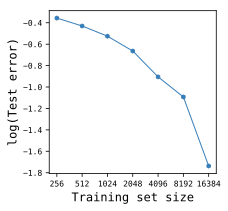

In [12]:
plot_figure("Training set size", "Test error", FLAGS["n_train_list"], 
            test_errors_list, xticks=FLAGS["n_train_list"])

And the bounds for varying dataset sizes:

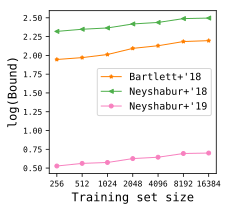

In [13]:
plot_figure("Training set size", "Bound", FLAGS["n_train_list"], bounds, xticks=FLAGS["n_train_list"], 
            ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

We observe that as we increase the dataset size, the test error decreases with the training set size, as expected. On the other hand, the bounds _increase_ with dataset size. And we observe this increase despite the fact that the denominator in these generalization bounds already have a $\sqrt{\text{training set size}}$ term. This is because, the weight norms of the network increase significantly with the dataset size. For example, below we plot the  distance from initialization and the spectral norms of the weight matrices:

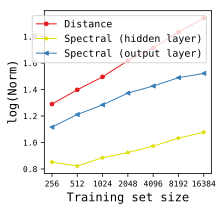

In [16]:
distances = [np.linalg.norm([np.linalg.norm(w[0]-w[1]) for w in zip(final_weights_list[k], initial_weights)]) for k in range(FLAGS["n_experiments"])]
hidden_layer_spectral_norm = [np.linalg.norm(final_weights_list[k][0],ord=2) for k in range(FLAGS["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(final_weights_list[k][2],ord=2) for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "Norm", FLAGS["n_train_list"], [distances, hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS["n_train_list"], 
            ylabels=["Distance", "Spectral (hidden layer)", "Spectral (output layer)"])

Thus, simple weight norms like distance from initialization and/or spectral norms have undesirable dependence on the dataset size. In certain hyperparameter settings (especially in smaller batch sizes), this dependence is adverse enough that,  as we add more datapoints to the training set, the bound cannot tell us whether the network is simply memorizing the training data or not. 

Unfortunately, _all_ existing neural network bounds depend on these kinds of weight norms, or some small variations of these. 
Hence, this means that our concern about the undesirable dataset size dependence is not only limited to the three bounds we experimented with, but all existing bounds in deep learning.

<p id="median-margin"></p>

### Median-margin based generalization guarantees

All this, of course, sounds bad. But a careful and hopeful reader may have noticed that we have not really tuned the $\gamma$ knob in favor of the generalization guarantee in Equation (1). Perhaps, by choosing larger values of $\gamma$, one can make the last term in the generalization bound (the one we have plotted above)  smaller since it has $\gamma$ in the denominator. Let us take this hope "to the extreme" by setting $\gamma$ to be the _median margin_ of the network on the training data.
That is, we enumerate the value of $f(x)[y] - \max_{y \neq k} f(x)[k]$ for every training point $(x,y)$ and then pick the median value of this quantity. We call this $\gamma_{\text{median}}$. Then, the generalization bound would look like:


$$\underbrace{Pr_{(x,y) \sim \mathcal{D}}[f(x)[y] < \max_{y \neq k} f(x)[k]]}_{\text{test 0-1 error}} \leq \underbrace{\color{red}{0.5}}_{\substack{\text{because only half the training data are} \\ \text{ classified by a margin of }\gamma_{\text{median}}}} + \frac{\text{some weight norms}}{ {\color{red}{\gamma_{\text{median}}}} \sqrt{m}}$$

The above generalization guarantee is already quite weak: the first term in the R.H.S. is as large as  $1/2$ and hence fails
to explain a significant part of the generalization behavior of the network (effectively, this bound does not tell us whether our learning algorithm is any better than a random classifier!). Nevertheless, it may still be worthwhile to look at the behavior of the last term above in this (useless) bound:





In [17]:
# Compute median margin based bounds 
median_bounds = [[],[],[]]

for k in range(FLAGS["n_experiments"]):
    # Reinitialize weights for every experiment
    reinitialize_weights(final_weights_list[k], weights_placeholder, reinitialize_op) 
    # The code below computes the median margin
    train_outputs = perform_op_over_data(train_inputs_list[k], train_labels_list[k], 
                                         network_output, input_placeholder, label_placeholder, FLAGS) 
    median_margin = np.median(get_margin(train_labels_list[k], np.vstack(train_outputs))) 
    
    spectral_norms = [np.linalg.norm(w,ord=2) for w in final_weights_list[k]]
    bound_0, bound_1, bound_2 = get_bounds(initial_weights, final_weights_list[k], spectral_norms, 
                                           median_margin, FLAGS["n_train_list"][k])
    median_bounds[0] += [bound_0]
    median_bounds[1] += [bound_1]
    median_bounds[2] += [bound_2]

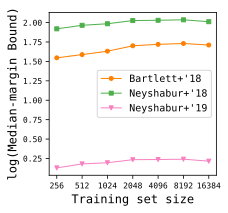

In [18]:
plot_figure("Training set size", "Median-margin Bound", FLAGS["n_train_list"], median_bounds,
            xticks=FLAGS["n_train_list"], ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

Unfortunately, we observe that even the median-margin-based bound increases with the dataset size (although, with a slightly smaller rate, perhaps staying constant or decreasing a bit towards the end). Thus, tuning the $\gamma$ term in Equation (1) is of little use to resolving the issues with the datasize-dependence in these generalization guarantees -- this implies that the poor dataset size dependence is indeed inherent to these generalization bounds.

This brings us to the end of Part 1. We summarize our insights from this part below:

---

## Takeaway from Part 1

 _Existing norm-based generalization guarantees (falsely) indicate that, as we add more datapoints to the training set, the network simply memorizes these datapoints.  Therefore, to truly understand generalization in deep learning, it is not only important to derive parameter-count-independent generalization guarantees, but also important to derive bounds whose dataset-size-dependence reflects that of the actual generalization error, at least to a reasonable extent._ 

---


<div align="right"><a href="#index">Back to index. </a></div>

# Part 2: The provable failure of uniform convergence

<p id="theory"></p>


Motivated by the fact that existing bounds have a hard time meeting the criteria for explaining generalization (appropriate paramter-count-dependence, datasize-dependence etc.,), in this section, we will investigate the theoretical technique underlying _all_ these bounds (PAC-Bayes, Rademacher, VC, covering numbers, compression etc.,): uniform convergence. Specifically, we will show through examples that _any_ uniform convergence bound, however tightly it is applied, fails to explain generalization in SGD-trained neural networks.

We first set up the notations, then define the standard notion of uniform convergence, and also define what we mean by a tight application of uniform convergence. 


## Preliminaries

Let $\mathcal{D}$ be an underlying distribution from which the training set $S$ of $m$ examples is drawn i.i.d. Assume we have an algorithm that, when given the dataset $S$, outputs a hypothesis $h_S$ that is picked from a hypothesis class $H$. (Throughout our discussion we assume that $h_S$ has zero error on $S$.) For any $h$, we let $\mathcal{L}_{\mathcal{D}}(h)$ denote the test error of $h$ (expected error over $\mathcal{D}$) and $\hat{\mathcal{L}}_S(h)$ the average empirical error over the dataset $S$.

We then define the __generalization error__ of this algorithm $\epsilon_{\text{gen}}$ as follows:

$$Pr_{S \sim \mathcal{D}^m} \left[ \underbrace{\mathcal{L}_{\mathcal{D}}(h_S)}_{\text{test error}} - \underbrace{\hat{\mathcal{L}}_{S}(h_S)}_{\text{training error}} \leq \epsilon_{\text{gen}}\right] \geq \underbrace{1-\delta}_{\text{except some unlucky dataset draws}}.$$


In other words, for most datasets $S$ (except for a few unlucky draws of $\delta$ probability), $\epsilon_{\text{gen}}$ denotes the difference in the test error and empirical error for the particular hypothesis $h_S$ learned on $S$. 

The standard __uniform convergence bound__ is a quantity $\epsilon_{\text{unif}}$ that is a (loose) upper bound on the generalization error.  This is defined by introducing a supremum over $H$ as follows:

$$Pr_{S \sim \mathcal{D}^m} \left[ {\sup_{h \in H}}  \left|\mathcal{L}_{\mathcal{D}}(h) - \hat{\mathcal{L}}_{S}(h)\right| \leq \epsilon_{\text{unif}}\right] \geq 1-\delta.$$

In other words, on most $S$, $\epsilon_{\text{unif}}$ bounds the difference between the test and empirical error simultaneously for all hypothesis in $H$ (not just for $h_S$!). Intuitively, such a bound grows with the "representational complexity" of the hypothesis class $H$. Quantities like VC-dimension, PAC-Bayes, Rademacher complexity etc.,  implement this kind of a bound in some way or the other.

As we saw in the beginning of our discussion, $H$ may be a rich hypothesis class, much of which is ignored by the algorithm for the given distribution $\mathcal{D}$, at least as far as deep learning is concerned. If one were to be cleverer, a natural alternative is to tighten these bounds by considering a supremum over a smaller class of hypotheses as visualized below.

<center>
<figure>
<div class="image-wrapper"><img src='smaller-class.png' alt='A smaller class of hypotheses' width="55%"/></div>
<figcaption><b>Figure</b>: We should apply uniform convergence on a smaller class of hypothesis, excluding complex hypotheses ignored by the algorithm.</figcaption>
</figure>
</center>

Of course, there are many different ways to choose a smaller class of hypothesis, and the smaller this class is, the tighter the uniform convergence bound. We are specifically interested in the smallest possible such class, that would yield the tightest uniform convergence bounds -- this is because we will later show that even this tightest notion of uniform convergence can fail in deep learning.

Now, how would one arrive at the tightest uniform convergence bound? Can we arbitrarily shrink the supremum to a very, small hypothesis class? For example, what if we restrict the supremum to a single hypothesis? Unfortunately, while that may yield an encouragingly small bound, it would not be a valid upper bound on $\epsilon_{\text{gen}}$. To yield a valid generalization bound, we must ensure that the shrunken hypothesis class contains at the least (almost) all the hypotheses output by the algorithm across all the draws of the training set. 

Thus, the tightest uniform convergence bound that also yields a valid generalization bound is one that is applied on a hypothesis class that contains _those_ and _only those_ hypotheses picked by the algorithm across different draws of the training set. Let us call this $H^\star$:

$$H^\star = \{h_S \; | \; S \sim \mathcal{D}^m \}$$

Clearly, this set ignores any hypothesis that is never picked by the algorithm. (In fact, to be more rigorous, we can truncate $H^\star$ a bit further, by ignoring hypotheses learned on a $\delta$ fraction of the possible training sets. Indeed, this is what we do in our paper. However, for the purposes of this blog, we will stick to this simpler definition of $H^\star$.) 

<center>
<figure>
<div class="image-wrapper"><img src='smallest-class.png' alt='A smaller class of hypotheses' width="65%"/></div>
<figcaption><b>Figure</b>: The smallest class of hypothesis on which we can apply uniform convergence to yield a valid generalization bound.</figcaption>
</figure>
</center>




We can then define the __tightest (algorithm,distribution)-dependent uniform convergence bound__ as a quantity $\epsilon_{\text{unif}}^\star$ for which:

$$Pr_{S \sim \mathcal{D}^m} \left[\sup_{h \in H^\star} \left|\mathcal{L}_{\mathcal{D}}(h) - \hat{\mathcal{L}}_{S}(h)\right| \leq \epsilon^\star_{\text{unif}}\right] \geq 1-\delta.$$

In the next subsection we will see how even this very clever (in fact, the most clever) application of uniform convergence falls apart in deep learning.

<div align="right"><a href="#index">Back to index. </a></div>

## A neural network example where even the tightest uniform convergence fails.


In our paper we present three different models -- including a ReLU network -- for which we demonstrate that uniform convergence fails to explain generalization. In this blog, we will focus on a slightly modified version of the hypersphere classification example from the paper. 

Below, we define the hyperparameter values: 


In [9]:
# Hyperparams
FLAGS_2 = {
"batch_size": 64, 
"input_dim": 500,
"n_classes" : 2,
"width" : 10000,
"depth" : 2,
"learning_rate" : 0.5,
"threshold" : 0.01, # Proportion of training points can we ignore
"margin" : 8, # Margin that needs to be achieved on most of the training points
"n_test" : 4096,
"inner_radius" : 1.0,
"outer_radius" : 1.2,
"n_train_list" : [1024,2048,4096,8192] # To experiment with larger dataset sizes,
    # one might have to increase the margin and the width hyperparameters.
}



__Note:__  The reader may wonder why we place the hyperspheres quite close to each other or why we have to train the network long enough to achieve a margin of $8$ on the training data. We explain the rationale behind this (and also the choice of the other hyperparameters) in the <a href="#close-margin">FAQ section</a>


Like in the previous section, we set up the network and the optimization graph below:

In [ ]:
input_placeholder_2 = tf.placeholder(tf.float32, shape=(FLAGS_2["batch_size"], FLAGS_2["input_dim"]))
label_placeholder_2 = tf.placeholder(tf.float32, shape=(FLAGS_2["batch_size"], FLAGS_2["n_classes"]))

# Create the network
with tf.variable_scope("train_2"):
    network_output_2 = get_network(input_placeholder_2, FLAGS_2["input_dim"], FLAGS_2["n_classes"], FLAGS_2["width"], FLAGS_2["depth"])
train_vars_2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "train_2")

# This is to save and reinitialize network
weights_placeholder_2 = [tf.placeholder(dtype=tf.float32, shape=t.shape) for t in train_vars_2]
reinitialize_op_2 = [train_vars_2[t].assign(weights_placeholder_2[t]) for t in range(len(weights_placeholder_2))]

# For optimization
cross_entropy_loss_op_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_placeholder_2,
                                                                                 logits=network_output_2))
opt_2 = tf.train.GradientDescentOptimizer(FLAGS_2["learning_rate"])
train_op_2 = opt_2.minimize(cross_entropy_loss_op_2, var_list=train_vars_2)

sess.run(tf.initialize_all_variables())
initial_weights_2 = sess.run(train_vars_2)

Next, we sample training datasets of varying sizes:

In [ ]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_inputs_2, test_labels_2 = get_random_data(FLAGS_2["n_test"], FLAGS_2["input_dim"], FLAGS_2["inner_radius"], FLAGS_2["outer_radius"])
FLAGS_2["n_experiments"] = len(FLAGS_2["n_train_list"])
train_inputs_list_2 = [[] for FLAGS_2["n_train"] in FLAGS_2["n_train_list"]]
train_labels_list_2 =  [[] for FLAGS_2["n_train"] in FLAGS_2["n_train_list"]]
for k in range(FLAGS_2["n_experiments"]):
    train_inputs_list_2[k], train_labels_list_2[k] =  get_random_data(FLAGS_2["n_train_list"][k], FLAGS_2["input_dim"], FLAGS_2["inner_radius"], FLAGS_2["outer_radius"])


To show that the tightest notion of uniform convergence, namely $\epsilon^\star_{\text{unif}}$, fails to explain generalization, we make use of the following lemma (proved in the paper).

---
**Lemma 1** Consider an algorithm that has zero training error and a test error of $\epsilon$ (on almost all draws of the training set). Assume the algorithm is such that, for nearly all draws of $S$, one can construct another dataset $S'$ of size $m$ (which can be depend on $S$) such that:

1. $h_S$ misclassifies $S'$ completely.
2. the distribution of $S'$ satisfies $S' \sim \mathcal{D}^m$ (note that $S'$ is a random variable that is a function of $S$, and here we want the distribution of $S'$, with $S$ marginalized out, to be equal to $\mathcal{D}^m$).

If the algorithm satisfies these requirements, then: 

<center>
$$\epsilon_{\text{unif}^\star} \geq  1-\epsilon$$.
    </center>

---

The proof for this lemma is simple and can be found in the paper. But informally, here's what is happening. On one hand, the algorithm generalizes well in that, for all but a few unlucky draws of $S$,
both the test error
$\mathcal{L}_{\mathcal{D}}(\cdot)$ and the empirical $\hat{\mathcal{L}}_{S}(\cdot)$ are $\epsilon$-close to each other _for the particular hypothesis $h_S$_ learned on $S$. But recall that a uniform convergence bound measures how close
$\mathcal{L}_{\mathcal{D}}(\cdot)$ and $\hat{\mathcal{L}}_{S}(\cdot)$ are, on almost all draws of the dataset $S$, and across all hypotheses in $H^\star$, simultaneously. If one can identify an $S'$ as stipulated by the lemma, one can show that there exists a "bad" dataset-hypothesis pair $(S,h)$ for which $h$ has an error of $1$ on $S$. Then, the empirical
$\hat{\mathcal{L}}_{S}(h)$ would be  $1$ which would be far apart from the test error $\mathcal{L}_{\mathcal{D}}(h)$ which is at most $\epsilon$, making the uniform convergence bound as large as $1-\epsilon$. 


### Can we design such an $S'$ for our task?

Yes, and the answer is quite simple: we design the bad dataset $S'$ merely by projecting every point in $S$ to its opposite hypersphere and flipping its label. That is, every point on the inner hypersphere is projected onto the outer hypersphere and vice versa, and then the labels are fixed accordingly. 


Does $S'$ satisfy the requirements of Lemma 1? Since the hypersphere distributions are uniform, it is easy to see that $S' \sim \mathcal{D}^m$. This satisfies the second condition in Lemma 1. At the same time, we can empirically demonstrate that $S'$ is misclassified by the hypothesis trained on S (see experiments below).
Then, by Lemma 1, it follows that even the tightest uniform convergence bound fails in this scenario. 

Note that in this example, we demonstrate the existence of  the bad dataset $S'$ empirically; in our other two examples in the paper, we derive closed form solutions for the decision boundary, which allows us to theoretically demonstrate the existence of $S'$.

Below, we create $S'$ for each of the training datasets that we sampled:

In [10]:

# We compute S' by projecting the training set
# on to the correspond opposite hyperspheres
projected_train_labels_list_2 =  [[] for n_train in FLAGS_2["n_train_list"]]
projected_train_inputs_list_2 = [[] for n_train in FLAGS_2["n_train_list"]]
for k in range(FLAGS_2["n_experiments"]):
    projected_train_labels_list_2[k] = 1-np.copy(train_labels_list_2[k]) # Flip labels
    projected_train_inputs_list_2[k] = np.copy(train_inputs_list_2[k])
    for i in range(FLAGS_2["n_train_list"][k]):
        if projected_train_labels_list_2[k][i,0] == 1:
            projected_train_inputs_list_2[k][i,:] = projected_train_inputs_list_2[k][i,:]*FLAGS_2["inner_radius"]/FLAGS_2["outer_radius"]
        else:
            projected_train_inputs_list_2[k][i,:] = projected_train_inputs_list_2[k][i,:]*FLAGS_2["outer_radius"]/FLAGS_2["inner_radius"]
            

We now train the network like before i.e., until almost all the training data are classified by a particular margin. 

In [ ]:
projected_train_errors_list_2 = [[] for k in range(FLAGS_2["n_experiments"])] # List of training errors on the projected training set across different experiments
final_weights_list_2 = [[] for k in range(FLAGS_2["n_experiments"])] # List of learned weights across the experiments
test_errors_list_2 = [0 for k in range(FLAGS_2["n_experiments"])] # List of test errors across the experiments

reinitialize_weights(initial_weights_2, weights_placeholder_2, reinitialize_op_2) # Reinitialize network every 
# time this block of code is run

for k in  range(FLAGS_2["n_experiments"]):
    print("Experiment no. "+str(k+1)+" running...")
    # Train
    epoch=0
    train_margin_error = 1.0
    while train_margin_error > FLAGS_2["threshold"]:
        epoch += 1
        # Update weights, compute output on training data and then the margin-based training error       
        perform_op_over_data(train_inputs_list_2[k], train_labels_list_2[k], train_op_2, input_placeholder_2, label_placeholder_2, FLAGS_2) 
        
        train_margin_error = get_margin_error(train_inputs_list_2[k], train_labels_list_2[k], network_output_2,
                                             input_placeholder_2, label_placeholder_2, FLAGS_2, FLAGS_2["margin"])  

        # Compute the error on the projected training set and test (just for monitoring)
        projected_train_error = get_margin_error(projected_train_inputs_list_2[k], projected_train_labels_list_2[k], network_output_2,
                                             input_placeholder_2, label_placeholder_2, FLAGS_2, 0.0)  
        test_error = get_margin_error(test_inputs_2, test_labels_2, network_output_2,
                                             input_placeholder_2, label_placeholder_2, FLAGS_2, 0.0)  
        print("Errors | Training: "+str(train_margin_error)+" Projected training: "+str(projected_train_error)+" Test:"+str(test_error))

    
    # Store the errors
    projected_train_errors_list_2[k] = projected_train_error            
    test_errors_list_2[k] = test_error
    final_weights_list_2[k]= sess.run(train_vars_2)  # Store weights
    reinitialize_weights(initial_weights_2, weights_placeholder_2, reinitialize_op_2)     # Reinitialize for next experiment

Below, we plot the test error of the network and the error on the projected dataset $S'$ for varying dataset sizes:

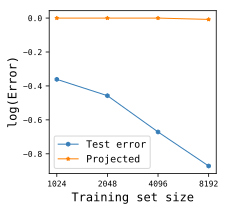

In [14]:
plot_figure("Training set size", "Error", FLAGS_2["n_train_list"], 
            [test_errors_list_2, projected_train_errors_list_2],
            xticks=FLAGS_2["n_train_list"], ylabels=["Test error", "Projected "])

We observe that even though the test error decreases with dataset size, the error on $S'$ remains constant at (or almost near) $1.00$, implying that $\epsilon_{\text{unif}}^{\star}$ is vacuous. Note that we did not explicitly modify the training in any way to make the network misclassify $S'$. It just so happens that SGD trains the network in a particular way that leads to misclassification of $S'$.

Intuitively, the misclassification of $S'$ means that the learned decision boundary near each training datapoint is skewed all the way into the opposite class, resulting in the closest point from the opposite class to be misclassified (visualized in 2D below). This also means that the learned decision boundary  is "complex" enough to "memorize" the locations of the training data (although at the same time, the decision boundary generalizes well).


<center>
<figure>
<div class="image-wrapper"><img src='complex-boundary.png' alt='The learning task' width="35%"/></div>
<figcaption><b>Figure</b>: The decision boundary is complex enough to have small skews located at each of the training datapoints.</figcaption>
</figure>
</center>

We conjecture that this sort of complexity co-exists with good generalization because:

- the decision boundary is "macroscopically simple", leading to good generalization.
- at the same time, the complex skews in the decision boundary are only "microscopic" (i.e., they  cover only low probability regions in the input space). Since they are microscopic, the skews will not affect the generalization error. However, uniform convergence, even the cleverest version of it, is not clever enough to ignore these skews, as encapsulated by Lemma 1. 

### Visualizing these complex boundaries 

#### Near the training set

Finally, we visualize these boundaries in the hypersphere dataset by consider 2D slices of the high-dimensional space.
Specifically, we pick pairs of training datapoints, and consider the 2D plane that contains these two points and then plot the learned boundary on this plane. The region classified as belonging to the inner hypersphere is colored brown, and the other blue.

Now, observe the curvature of the boundary _right near_ each training datapoint. If the training datapoint is on the inner sphere, the boundary near the point juts out all the way into the outer sphere; if it is on the outer sphere, the boundary near the point is tightly squeezed within the inner sphere. This leads to misclassification of the projected versions of these training datapoints.


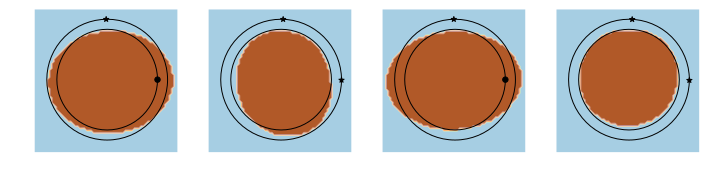

In [15]:
k=-1 # Pick the experiment corresponding to the largest dataset
reinitialize_weights(final_weights_list_2[k], weights_placeholder_2, reinitialize_op_2)
plot_slices(4, train_inputs_list_2[k], train_labels_list_2[k], 
           network_output_2, input_placeholder_2, label_placeholder_2, FLAGS_2)

#### Near the test set
 
Below, we perform the same visualization for a 2D plane passing through two random _test_ datapoints. Observe that a large fraction of these test datapoints are classified correctly, unlike the projected versions of the training datapoints which are misclassified. 

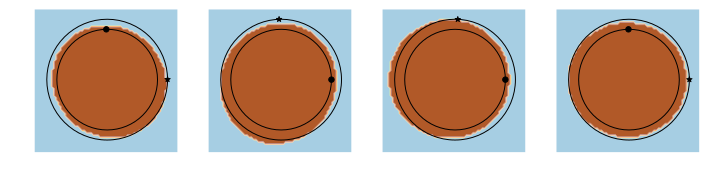

In [16]:
plot_slices(4, test_inputs_2, test_labels_2,
           network_output_2, input_placeholder_2, label_placeholder_2, FLAGS_2)


---

## Takeaway from Part 2

_Overparameterized models trained by gradient descent can have certain complexities in their decision boundary; on one hand, these complexities need not hurt generalization error. However, they can severly hurt uniform convergence based bounds. Thus, uniform convergence may not be able to fully explain generalization in deep learning._ 

---

<div align="right"><a href="#index">Back to index. </a></div>

# Looking ahead


In summary, we demonstrated two issues with uniform convergence based generalization bounds in deep learning:

- these bounds increase with the training dataset size, and thus, do not explain a crucial aspect of the generalization behavior.
- the decision boundaries learned by deep networks can be complex enough to render any uniform convergence bound meaningless, despite good generalization.



In light of this, we believe that it is time to:

- **explore other ways of deriving generalization bounds for deep networks**. This means, we might either have to try other tools (like variations of algorithmic stability) or develop new tools (for which our examples may be a good test case).

- **better understand how these kinds of complexities arise in the decision boundaries**. Can we mathematically characterize the "bad" sub-component of the deep network that contributes to these skews in the decision boundary? By doing so, we may even be able to arrive at a different technique for proving generalization in deep learning. For example, imagine we are able argue why the  "bad" sub-component of the deep network does not affect the network's output (on most inputs). Perhaps, the remaining, "good" sub-component does yield tight uniform convergence bounds after all (similar to existing tight bounds on stochastic/compressed networks). Then, by using the (hypothetical) fact that the bad sub-component does not affect the output for most inputs, one can extend this uniform convergence bound on the smaller network to the original network. Revisting some existing work on modified networks may help verify this hypothesis.

<p id="faqs"> </p>


# FAQs

Below, we have compiled a list of questions that have been frequently asked about the results in our paper. We have addressed most of these already in the paper (see sections titled "remark" in our paper). However, since these are spread across the paper, we hope that the reader finds this compiled list useful. 

Some of these questions were directly/indirectly raised by others from later discussions -- we thank Vitaly Feldman, Jason D. Lee, Tengyu Ma and David Reeb for bringing these up.


Note: Some parts of this discussion may require familiarity with parts of our paper that are not covered in the blog.


<p id="faqs-experiments"></p>


### About the bounds vs. dataset size plots

__Q. The cross-entropy loss is minimized only when the parameters go to infinity. Hence, it seems like these problematic plots are a crazy artifact of cross-entropy loss.__


__A.__ This point suggests that these plots are symptomatic of some superficial phenomenon in our setup. 
On the contrary, we have two main reasons to believe that these plots indicate fundamental problems with the current approach of using weight norms to understand generalization in deep networks 


First, we observe these plots even for squared error loss; we present these plots in the appendix; we also refer the reader to plots in  [Nagarajan and Kolter 2017](https://arxiv.org/abs/1901.01672).
Secondly, we must emphasize that margin-based generalization bounds do take care of "scaling down" networks that have been trained to minimize cross-entropy loss. Recall that these bounds have the following form: 

$$\begin{align}\underbrace{Pr_{(x,y) \sim \mathcal{D}}[f(x)[y] < \max_{y \neq k} f(x)[k]]}_{\text{test 0-1 error}} \leq & \underbrace{\frac{1}{m} \sum_{(x,y) \in S} \mathbf{1}[f(x)[y] < \max_{y \neq k} f(x)[k]{\color{red}+} {\color{red}\gamma}]}_{\text{proportion of training points misclassified by a "margin" of } \gamma}\\& + \mathcal{O}\left(\frac{\text{some weight norms}}{ {\color{red}\gamma} \sqrt{m}}\right)\end{align}$$

Now, networks that have been trained for longer and hence have larger norms, are more likely to have larger margins on the training data. Then, one should be able to tune up the knob $\gamma$ in the generalization guarantee to be proportionally as large as the margins on the training data while ensuring that the first term on the right hand side is still zero. At the same time, in the second term on the right hand side, such a large $\gamma$ in the denominator would hopefully counter the large magnitudes of the weights in the numerator. Recall from our section on "median-margin-based generalization bounds" that despite tuning up $\gamma$ quite generously, the bounds still did a bad job at how they should vary with the dataset size. 


__Q. What happens when we increase the training set size even further up in our generalization bounds vs. datasize plots?__

__A.__ Based on our experiments in infiMNIST where we doubled the dataset until it was 16 times larger, we observed that the bounds continued increasing. Our guess is that this sort of an increase would be observed until the setting becomes underparameterized. In some sense, as we add more and more data, a small part of the decision boundary becomes skewed (adding more complexity, increasing the norm); the number of such skews should be bounded by the maximum capacity of the model -- the parameter-count.


__Q. Here's another hypothesis that should explain why the bounds increase with dataset size. It's possible that there are some outlier examples in MNIST, which are quite difficult for the network to fit. With more and more training data, there are more and more such outlier examples, thus the network has to fit these examples. And so, if not for these outlier examples, the network will probably not exhibit such a behavior, and uniform convergence may indeed hold in that case.__

__A.__ Although a valid possibility, we think that the hypersphere example is sufficient to counter this reasoning: in that example, there's no datapoint that is "more difficult/outlier-ish" than another, since the distribution is identical along all directions.







<p id="faqs-uc"></p>


### About the definition of uniform convergence

__Q. The examples in this paper, where uniform convergence is shown to fail, critically depend on the fact that the definition of uniform convergence is two-sided i.e., the bound is on the _absolute_ value of the difference between the test error and the empirical error. So can't we circumvent the problem in these examples by using one-sided uniform convergence bounds?__

__A.__ Good news: this is absolutely right -- one-sided uniform convergence bounds do work in our examples. 

Bad news: existing uniform convergence-based tools
are all two-sided. This is because it is much easier to derive an upper bound that holds on the absolute difference between the test and train error than on a one-sided difference. Currently, one-sided uniform convergence is only a hypothetical entity. 


__Q. Aren't PAC-Bayes bounds one-sided?__

__Answer:__ Unfortunately, no. The one-sided version that bounds the difference between the test and train loss of a stochastic network
comes from a two-sided version that bounds the KL-divergence between these two losses. We can show that this KL-divergence-based bound also implies a bound on our "tightest uniform convergence bound" which is an absolute difference between the test and train losses
(we show this in the appendix of our paper).


__Q. Although PAC-Bayes bounds hold simultaneously across all stochastic classifiers (for a given dataset draw), for each stochastic classifier, it yields a different numerical value specific to that classifier. However, the definition of uniform convergence in this paper corresponds to just a single numerical value that holds for all the classifiers output by the algorithm. Given this disparity, do PAC-Bayes bounds really fit the definition of uniform convergence in this paper? In other words, do the examples in this paper really apply to PAC-Bayes bounds too?__


__A:__ This is a subtle point and requires a detailed answer. We argue why our definition applies to PAC-Bayes bounds too, at least, the deterministic/derandomized ones. 


Indeed, as the question states, PAC-Bayes bounds, can be written as follows: 

$$\text{w.h.p of }1-\delta\text{ over }S\sim\mathcal{D}^m,\text{for all stochastic classifiers Q}, \\ |\mathcal{L}_{\mathcal{D}}(Q) - \hat{\mathcal{L}}_{\mathcal{S}}(Q) | \leq \mathcal{O}\left(\frac{\text{some complexity of }Q}{\sqrt{m}}\right)$$

That is, for different stochastic classifiers $Q$, the right hand side evaluates to different values. 
In practice, one usually reports the right hand side evaluated for a specific classifier $Q$ centered at the weights learned by SGD for a particular draw of $S$ (this is true even of most other bounds, not just PAC-Bayes bounds). Even though such a bound may be a practically interesting quantity, strictly speaking, such a bound in itself is not a theoretically rigorous upper bound on the test error of the learned hypothesis. This is because, the above statement does not guarantee whether the "w.h.p over $S$" includes the training set that we just drew. Hence, we would not know whether the upper bound in this statement holds for the difference between the test error and empirical error on the particular dataset $S$. 

There is only one way to get a rigorous, valid generalization bound from the above statement and that would be a bound 
that holds for the algorithm itself and not a specific classifier. To derive this, we must
first compute the right hand side for many independent draws of the dataset $S$ (upto at least $1-\delta$ probability mass of them). Then, we will be able to safely guarantee that the maximum of the values obtained across these datasets, is an upper bound on $\epsilon_{\text{gen}}$, the generalization error of the algorithm (i.e., an upper bound that holds for not just one hypothesis, but for almost all hypotheses output by the algorithm). 

Thus, in effect, for a valid generalization bound, we will have to compute the supremum of the PAC-Bayesian bound over multiple different hypotheses relevant to the algorithm. This supremum cannot be tighter than the tightest uniform convergence bound we defined (that we then lower bounded in our examples).




__Q. What about data-dependent uniform convergence bounds for deep networks like in [Nagarajan & Kolter, 2019 (a)](https://arxiv.org/abs/1905.13344) or [Wei and Ma, 2019](https://arxiv.org/abs/1905.03684)? Don't they circumvent the issues in the examples shown in the paper?__

__A:__ This is a clever question and demands a detailed answer. Recall that in a data-dependent uniform convergence bound, the supremum over the hypothesis space $H^\star$ is replaced by a hypothesis set $H_S$ that is dependent on $S$ and hopefully smaller than the data-independent $H^\star$:


$$Pr_{S \sim \mathcal{D}^m} \left[\sup_{h \in H_S} \left|\mathcal{L}_{\mathcal{D}}(h) - \hat{\mathcal{L}}_{S}(h)\right| \leq \epsilon^\star_{\text{unif}}\right] \geq 1-\delta$$

Now, in our examples, recall that, for any $S$, there is a corresponding "bad" $h \in H^\star$ with large error on $S$, resulting in vacuous uniform convergence. A data-dependent uniform convergence bound would resolve this issue only if it is sophisticated enough to weed out such bad hypotheses from $H_S$.

Clearly, if we had a data-dependent bound for which $H_S = \{h_S \}$, we would not run into trouble (in fact, it would be misleading to call such a hypothetical bound, a "uniform convergence" bound in any sense). This is precisely what is achieved by stability-based bounds.


However, deriving this kind of bound is quite hard, and the techniques in  [Nagarajan & Kolter, 2019 (a)](https://arxiv.org/abs/1905.13344) or [Wei and Ma, 2019](https://arxiv.org/abs/1905.03684) do something a lot less clever. These bounds essentially define $H_S$ to be the set of hypotheses with bounded data-dependent norms (like the $\ell_2$ norms of the Jacobians). This kind of characterization does not exclude "bad" hypotheses from $H_S$ which impair uniform convergence (as in, there is no reason why the bad hypotheses for a particular dataset, would not satisfy these Jacobian-norm bounds). One would require a significantly more sophisticated technique to circumvent the issues highlighted in our examples.



__Q. Recent works like [Arora et al., 2019](https://arxiv.org/abs/1901.08584) have shown parameter-count-independent bounds that hold on the original network. Don't these bounds explain generalization in deep learning?__

__A.__ While these bounds are certainly progress in some sense, there are other ways in which they still don't fully explain generalization -- the main issue being the fact that these are uniform convergence bounds and these are based on simple weight norms which grow with dataset size. Besides this, these bounds typically require specific choices of small learning rates which are tuned according to the dataset size. Hence, we believe that these bounds still do not capture a significant part of the generalization behavior.


__Q. Works like [Dziugate and Roy., 2017](https://arxiv.org/abs/1703.11008) and [Zhou et al., 2019](https://arxiv.org/abs/1804.05862) have been able to compute non-vacuous bounds in deep learning. Don't the negative results about uniform convergence contradict these existing works?__

__A.__ We don't think there's any contradiction here. Our result only implies that uniform convergence may not yield strong bounds on the _original_ network learned by SGD. It is still completely possible to modify the network in different ways to yield stronger bounds on the modified network, like these works have done. For example, in [Dziugate and Roy., 2017](https://arxiv.org/abs/1703.11008) the network is modified by adding noise, besides explicitly optimizing it further to reduce a PAC-Bayesian bound. (Intuitively, adding noise makes the network less dependent on the training data than the deterministic network learned by SGD, which helps in getting better bounds.) 


<p id="faqs-examples"></p>


### About the examples of vacuous uniform convergence

   <p id="close-margin"></p>
 
    
__Q. In these examples, the two classes are placed very close together. Isn't this only a special case where uniform convergence would fail? What happens when the classes are far apart? Also, what happens if we stop the network earlier?__


__A:__ Indeed, when the spheres are far apart, the neural network achieves near-zero test error; thus, the projected dataset $S'$ will no longer be misclassified, and $\epsilon_{\text{unif}}^\star$ is probably zero too. Furthermore, if we stop the network quite early, the test error may still be small and the dataset $S'$ may no longer be misclassified.

However this does not make our examples restrictive. This is because our lower bound is on a _really_ powerful uniform convergence bound (namely, $\epsilon_{\text{unif}}^\star$) that has complete knowledge of the underlying data distribution $\mathcal{D}$. And to show that even this powerful bound fails, we do need such closely placed class distributions and train the network for a sufficiently long time. Intuitively, we want the class boundaries of the network to fall within the tiny "skews" around the training data, to bring about the failure of uniform convergence. And to make these skews sufficiently large in practice, one needs to bring the classes closer and train longer. (Note that we do not _artificially_ create these skews by modifying the learning algorithm. These skews are solely a creation of vanilla SGD; we simply "rescale" the environment in a way that makes observing these skews better!

In reality, one does far from computing this powerful uniform convergence bound.
Most implementations of uniform convergence (such as those applied for MNIST) do not make any assumptions about the underyling data beyond simple assumptions like bounds on the $\ell_2$ norm of the data. Our intuition is that, even when the classes are far apart, one can still find skews in the decision boundary -- just that they may not leak into the opposite class. However, weakly-distribution-dependent uniform-convergence bounds would still perceive these skews as overfit to the training data, and hence fail in these cases. 

Now,  even if we did use our knowledge of the underlying distribution to apply uniform convergence in these cases (say, we assume a specific underlying data distribution), we believe that tools which implement uniform convergence -- like  Rademacher complexity or PAC-Bayes bounds -- are not  sophsticated enough to ignore such skews. We would have to explicitly ignore these skews (and argue why they don't affect the generalization error) and then apply these tools only on the modified network (which is basically what we propose for future work). 

__Q. In these examples, what happens if the number of training datapoints increases?__

__A:__ It's very likely that the test error of the network drops completely to zero, or to some small number, while the error on the projected dataset dips too. In order to observe a larger error on the projected dataset, one may have to:

- bring the hyperspheres closer together 
- increase the network capacity
- train the network for longer.

Nevertheless, for a specific configuration of the hyperparameters, one can always find sufficiently large datasets for which the error on the projected dataset is quite small. However, we emphasize that this does not absolve uniform convergence of its flaws. Regardless of such phase transition beyond a particular training set size, the fact is that uniform convergence provably and (miserably) fails to explain generalization until before that point.


__Q. One of the examples presented in the paper is a linear classifier. This seems too simplistic. What insight does this example give?__

__A.__ First, we must emphasize that showing failure of uniform convergence for a simpler model is in a sense harder than showing its failure for a more complicated model. 

One is still right in wondering if such a model provides some insight about deep learning. While our neural network examples concretely establish failure of uniform convergence in deep learning, we hope that the linear example provides some intuition into the _mechanism_ by which uniform convergence fails, from which we can draw intuition about deep learning keeping in mind the recently established similarities to linearized deep networks [[Jacot et al., 2018]](https://arxiv.org/abs/1806.07572). 

Let us do a quick recap of the mechanism by which uniform convergence fails in our linear example. In this example, there are many more features than training datapoints, and most of these features are useless. The learned classifier inadvertently assigns some weights to these useless features. Now, although the weights corresponding to these meaningless features do not contribute to the classifier's output on most test inputs, they do affect the output in small parts of the input space. We show how this results in a complex decision boundary, leading to failure of uniform convergence without hurting generalization.

Similarly, recall that under some conditions, in the infinite-width setting, deep learning models can be thought of as overparameterized linearized model whose features can be computed from the outputs of the random initialization of the network [[Jacot et al., 2018]](https://arxiv.org/abs/1806.07572). (In other words, these models can be thought of as random features models). Our intuition is that most directions in this random features space are meaningless. Like in our linear example, although gradient descent probably adds a lot of weight to the useful features, it also inadvertently adds some weight to the meaningless features, which result in complex error regions, without hurting generalization. 



<p id="faqs-related-work"></p>

### About related work



__Q. Didn't [Zhang et al., 2017](https://arxiv.org/abs/1611.03530) already prove these negative results about uniform convergence?__

__A.__ No, [Zhang et al., 2017](https://arxiv.org/abs/1611.03530) showed that the standard application of uniform convergence (which is an extremely naive application) over the whole space of functions represented by a deep network is vacuous. They suggested that, perhaps, applying uniform convergence on smaller class of function relevant to SGD, may yield meaningful bounds. Subsequently, many papers attempted this in one way or the other. Our result argues that even this kind of approach would be futile in deep learning because uniform convergence is fundamentally weaker in other intricate ways  for deep learning models. 



__Q. Isn't uniform convergence already known to fail in kNNs?__

__A.__ Indeed the VC dimension of kNNs is known to be infinite, as a result of which algorithmic stability based techniques are used to study generalization in these models. However this intuition in a non-parametric model does not  extend to parameteric models trained by gradient descent. Furthermore, we rigorously show how even the tightest algorithm-dependent & distribution-dependent uniform convergence can fail even when the algorithm has small test/train error (and this sort of intuition for kNN models is only folklore wisdom to the best of our knowledge).

__Q. Didn't [Shalev-Shwartz et al.,](https://dl.acm.org/citation.cfm?id=1953019) show that uniform convergence provably fails in some cases?__

__A.__ Their result is _completely_ orthogonal to ours (i.e., neither stronger, nor weaker, nor equivalent). In formal terms, their work is about showing that for "a learning problem", it is possible for (a distribution-independent version of) uniform convergence to not hold even though the problem is "learnable". The notions of "a learning problem" and "learnability" are formal terms that are not relevant to our discussion in this paper. Roughly speaking, a learning problem is defined solely by a hypothesis class and a loss function (like the 0-1 error) -- but not by the underlying data distribution. And if the learning problem is learnable, it means that there is __some__ learning rule  such that, for __all__ underlying data distributions, the learning rule uses the training data to pick a near-optimal hypothesis from the hypothesis class.

[Shalev-Shwartz et al.,](https://dl.acm.org/citation.cfm?id=1953019) show that "uniform convergence does not imply learnability of a general learning problem". Specifically, they construct a
stochastic optimization problem (_not_ a binary classification problem) for which, even though there exists a learning rule that picks a near-optimal hypothesis (from the given hypothesis class) for all complex data distributions, distribution __independent__
uniform convergence does not hold. 

As far as binary classification problems are concerned [Shalev-Shwartz et al.,](https://dl.acm.org/citation.cfm?id=1953019) themselves note that uniform convergence is equivalent to learnability in binary classification problems.
On the other hand, our result establishes an orthogonal negative link between uniform convergence and binary classification. Specifically, we show for a binary classification task that, for the __particular__ learning rule of gradient descent, and for a __particular simple__ class of distributions, even though the learning rule picks a good hypothesis, even distribution __dependent__ and algorithm-dependent uniform convergence fails.




__Q. Previous works like [Belkin et al., 2018](https://arxiv.org/abs/1802.01396) have studied interpolation (i.e., training models to zero squared error loss). Doesn't this already show that norms grow with dataset size in overparameterized models?__

__A.__  We extend this observation in two crucial ways. First [Belkin et al., 2018](https://arxiv.org/abs/1802.01396) show that in kernel learning,
_when the labels are corrupted with non-zero amounts of noise_, the kernel norms (that
appear in kernel generalization bounds) increase with dataset size. Now, it is
reasonable to expect that, when the model is forced to fit more and more noise (with
more and more training data), it must increase its capacity to memorize such
information – resulting in larger norms. What happens when there is no noise in the
labels? We show that even when there is no label noise, the norms (and also the generalization bounds) can increase adversely, which is much more concerning. 

Another important distinction is that [Belkin et al., 2018](https://arxiv.org/abs/1802.01396) conduct their experiments on the squared error loss, while we study the cross-entropy loss. When minimizing the squared-error loss, the network is forced to reproduce the _exact_ real-value of the labels at the training datapoints. This is significantly harder than what it is expected to do under cross-entropy loss: simply reproduce the _sign_ of these labels. Hence, it is more surpising that even for this easy goal, the norms of a network grow as it is made to fit (the signs) of the labels of of more and more training datapoints.

__Q. [Neyshabur et al., 2017](https://arxiv.org/abs/1706.08947) and [Nagarajan and Kolter 2017](https://arxiv.org/abs/1901.01672) reported norms that increase with dataset size even when there's no label noise under the cross-entropy loss. What is the new insight from the plots in this paper?__

__A.__ [Neyshabur et al., 2017](https://arxiv.org/abs/1706.08947) and [Nagarajan and Kolter 2017](https://arxiv.org/abs/1901.01672) indeed show increasing norms vs dataset size plots for non-noisy labels.
Although one can see that the norms increase with dataset size in those plots, their 
discussions focus only on parameter-count-dependence; on the other hand, we highlight datasize-dependence as an important aspect of generalization, and we investigate this aspect in detail in different settings. 

More specifically, although these previous plots demonstrate that the norms increase with dataset size, it is not clear if this increase is concerningly large enough to affect the generalization bounds (since there is a $\sqrt{\text{training set size}}$ factor in the denominator of these bounds). We demonstrate that there do exist certain hyperparameter settings where the generalization bounds are affected adversely (despite the $\sqrt{\text{training set size}}$ in the denominator). We also take a closer look at this phenomenon by optimizing the margin parameter in these bounds (see <a href="#median-margin">experiments on median margins</a>) and by studying other related phenomena like pseudo-overfitting (not covered in our blog).




